In [12]:
import numpy as np
import pandas as pd
import torch
import re
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from gensim.utils import tokenize


In [20]:
# load file with the data collection

file_path = "mountain_sentance_collection.csv"
df = pd.read_csv(file_path)
df.fillna({'Entity': 'NoEntity', 'Start': -1, 'End': -1}, inplace=True)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
df.head()

,Sentence,Entity,Start,End
0,Mount Everest is the highest mountain in the w...,Mount Everest,0.0,13.0
1,The climbers faced harsh weather conditions on...,K2,47.0,48.0
2,mt kilimanjaro hike difficulty level,Mount Kilimanjaro,0.0,13.0
3,Mount Fuji sunrise viewing spots,Mount Fuji,0.0,9.0
4,best viewpoints to see elbrus mountain,Mount Elbrus,23.0,28.0


In [21]:
def label_entities(sentence, entity, start, end):
    tokenize_sentence = sentence.lower().split()  # Tokenize the sentence (convert to lowercase for case-insensitivity)
    entity = entity.lower().split()  # Tokenize the entity (convert to lowercase for case-insensitivity)
    entity_label = [0] * len(tokenize_sentence)  # Initialize entity labels as 0 (for the begging)
    
    for i, token in  enumerate(tokenize_sentence):
        start_idx = sentence.lower().find(token.lower())
        end_idx = start_idx + len(token) - 1
        
        # if index of token between defined positions than it's mountain
        if (start <= start_idx <= end and start <= end_idx <= end):
            entity_label[i] = 1

    return tokenize_sentence, entity_label

train_data = [label_entities(row['Sentence'], row['Entity'], int(row['Start']), int(row['End'])) for _, row in train_df.iterrows()]
val_data = [label_entities(row['Sentence'], row['Entity'], int(row['Start']), int(row['End'])) for _, row in val_df.iterrows()]


In [22]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

# Tokenize and pad sentences, and create attention masks
def tokenize_and_pad(data):
    sentences, labels = zip(*data)
    tokenized_inputs = tokenizer(sentences, padding="max_length", truncation=True, return_tensors="pt", is_split_into_words=True)
    max_seq_length = 512
    
    input_ids = tokenized_inputs["input_ids"]
    attention_masks = tokenized_inputs["attention_mask"]

    
    padded_labels = []
    for label in labels:
        if len(label) < max_seq_length:
            label = label + [0] * (max_seq_length - len(label))
        elif len(label) > max_seq_length:
            label = label[:max_seq_length]
        padded_labels.append(label)
    
    labels = torch.tensor(padded_labels)

    return input_ids, attention_masks, labels


# Preparing the training and validation data
train_input_ids, train_attention_masks, train_labels = tokenize_and_pad(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_and_pad(val_data)



In [23]:
batch_size = 16  # Adjust as needed

train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [24]:
# SELECT MODEL

model = RobertaForTokenClassification.from_pretrained(
    "roberta-base", # has better performance than BERT
    num_labels = 2,  # 2 for binary classification
    output_attentions = False,  
    output_hidden_states = False, 
)


optimizer = AdamW(model.parameters(), lr=5e-5)

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/katework/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [25]:
# Number of training epochs
num_epochs = 4

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    total_val_loss = 0

    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_val_loss += loss.item()
        
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} | Validation Loss: {avg_val_loss:.4f}")
    

Epoch 1/4 | Train Loss: 0.3350
Epoch 1/4 | Validation Loss: 0.0537
Epoch 2/4 | Train Loss: 0.0324
Epoch 2/4 | Validation Loss: 0.0157
Epoch 3/4 | Train Loss: 0.0137
Epoch 3/4 | Validation Loss: 0.0157
Epoch 4/4 | Train Loss: 0.0151
Epoch 4/4 | Validation Loss: 0.0136


In [26]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(label_ids)

    # Flatten the predictions and true labels
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Convert logits to class predictions
    flat_predictions = np.argmax(flat_predictions, axis=2).flatten()
    flat_true_labels = flat_true_labels.flatten()

    return classification_report(flat_true_labels, flat_predictions, labels=[0,1], zero_division=1)

# Evaluate on validation set
report = evaluate_model(model, val_dataloader)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5108
           1       1.00      0.00      0.00        12

    accuracy                           1.00      5120
   macro avg       1.00      0.50      0.50      5120
weighted avg       1.00      1.00      1.00      5120



In [27]:
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            # Convert logits to class predictions
            batch_predictions = np.argmax(logits, axis=2).flatten()
            batch_true_labels = label_ids.flatten()

            predictions.extend(batch_predictions)
            true_labels.extend(batch_true_labels)

    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
predictions, true_labels = get_predictions(model, val_dataloader)


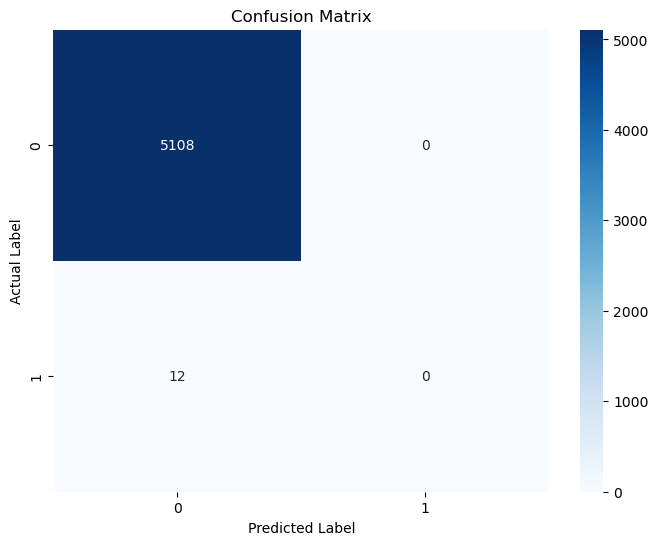

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [29]:
model.save_pretrained('./model_weights/')

In [30]:
tokenizer.save_pretrained('./model_weights/')

('./model_config/tokenizer_config.json',
 './model_config/special_tokens_map.json',
 './model_config/vocab.json',
 './model_config/merges.txt',
 './model_config/added_tokens.json',
 './model_config/tokenizer.json')